# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road**
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below.

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="https://github.com/Joginaidu9014/Lane_Detection/blob/main/examples/line-segments-example.jpg?raw=1" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p>
 </figcaption>
</figure>
 <p></p>
<figure>
 <img src="https://github.com/Joginaidu9014/Lane_Detection/blob/main/examples/laneLines_thirdPass.jpg?raw=1" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p>
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [ ]:
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display plots inline in Jupyter
%matplotlib inline


## Load and Display a Sample Image


In [ ]:
# Load a test image
image_path = '/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_images/solidWhiteRight.jpg'  # Update path if needed
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.title("Original Road Image")
plt.axis('off')
plt.show()

# mpimg.imread: Reads image in RGB format (useful for visualization)
# plt.imshow: Plots the image
# plt.axis('off'): Hides axis ticks


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image



## Step-by-Step: Core Image Processing Functions
We'll now create modular, clean, and well-commented functions for the lane detection pipeline.

In [ ]:
# 1. Grayscale Conversion

def grayscale(img):
    """
    Converts the input image to grayscale.
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [ ]:
#  2. Gaussian Blur

def gaussian_blur(img, kernel_size=5):
    """
    Applies a Gaussian Noise kernel to the image.
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


In [ ]:
# ⚫ 3. Canny Edge Detection

def canny(img, low_threshold=50, high_threshold=150):
    """
    Applies the Canny edge detector to the image.
    """
    return cv2.Canny(img, low_threshold, high_threshold)


In [ ]:
# 4. Region of Interest Masking

def region_of_interest(img):
    """
    Applies an image mask to focus only on the region of interest (the lane area).
    """
    height, width = img.shape[:2]
    mask = np.zeros_like(img)

    # Define a polygon mask (this can be adjusted based on your camera angle)
    polygon = np.array([[
        (int(0.1 * width), height),
        (int(0.45 * width), int(0.6 * height)),
        (int(0.55 * width), int(0.6 * height)),
        (int(0.95 * width), height)
    ]], dtype=np.int32)

    cv2.fillPoly(mask, polygon, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [ ]:
#  5. Drawing Lines

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Draws lane lines averaged/extrapolated from the given Hough lines.
    """
    if lines is None:
        return

    left_lines, right_lines = [], []

    for line in lines:
        for x1, y1, x2, y2 in line:
            # Calculate slope
            slope = (y2 - y1) / (x2 - x1 + 1e-6)
            if slope < -0.5:
                left_lines.append((x1, y1, x2, y2))
            elif slope > 0.5:
                right_lines.append((x1, y1, x2, y2))

    def make_line(points):
        if len(points) == 0:
            return None
        x_coords = [p[0] for p in points] + [p[2] for p in points]
        y_coords = [p[1] for p in points] + [p[3] for p in points]
        poly = np.polyfit(y_coords, x_coords, 1)
        y1, y2 = img.shape[0], int(img.shape[0] * 0.6)
        x1, x2 = int(np.polyval(poly, y1)), int(np.polyval(poly, y2))
        return ((x1, y1), (x2, y2))

    left_line = make_line(left_lines)
    right_line = make_line(right_lines)

    if left_line:
        cv2.line(img, left_line[0], left_line[1], color, thickness)
    if right_line:
        cv2.line(img, right_line[0], right_line[1], color, thickness)


In [ ]:
# 6. Hough Transform to Detect Lines

def hough_lines(img, rho=2, theta=np.pi/180, threshold=50, min_line_len=100, max_line_gap=160):
    """
    Applies Hough Line Transform to detect lines in edge-detected image.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


In [ ]:
#  Final Pipeline Function: All Steps Together

def lane_detection_pipeline(image):
    gray = grayscale(image)
    blurred = gaussian_blur(gray)
    edges = canny(blurred)
    roi = region_of_interest(edges)
    line_img = hough_lines(roi)

    # Combine with original image
    output = cv2.addWeighted(image, 0.8, line_img, 1.0, 0)
    return output


## ✅ Let's Test It on an Image:

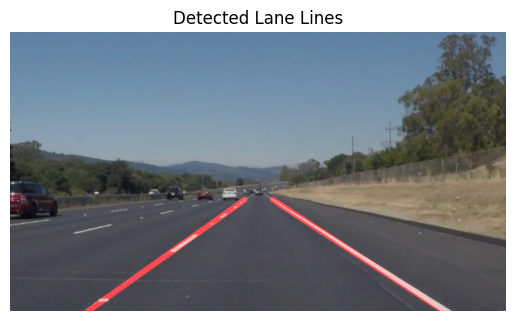

In [ ]:
# Load an image and test the pipeline
test_image = mpimg.imread('/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_images/solidWhiteRight.jpg')
result = lane_detection_pipeline(test_image)

# Show the result
plt.imshow(result)
plt.title("Detected Lane Lines")
plt.axis('off')
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lane detection pipeline definition
def advanced_lane_detection_pipeline(image):
    image = cv2.resize(image, (960, 540))
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    height, width = edges.shape
    mask = np.zeros_like(edges)
    polygon = np.array([[
        (int(0.1 * width), height),
        (int(0.45 * width), int(height * 0.6)),
        (int(0.55 * width), int(height * 0.6)),
        (int(0.9 * width), height)
    ]], dtype=np.int32)
    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(cropped_edges, 1, np.pi/180, 40, minLineLength=40, maxLineGap=100)
    left_lines = []
    right_lines = []

    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if x2 == x1:
                    continue
                slope = (y2 - y1) / (x2 - x1)
                if abs(slope) < 0.5:
                    continue
                if slope < 0:
                    left_lines.append((x1, y1, x2, y2))
                else:
                    right_lines.append((x1, y1, x2, y2))

    def make_line(points, y_min, y_max):
        if not points:
            return None
        x = []
        y = []
        for x1, y1, x2, y2 in points:
            x += [x1, x2]
            y += [y1, y2]
        poly = np.polyfit(y, x, 1)
        x1, x2 = int(np.polyval(poly, y_max)), int(np.polyval(poly, y_min))
        return (x1, y_max, x2, y_min)

    y_max = height
    y_min = int(height * 0.6)
    left = make_line(left_lines, y_min, y_max)
    right = make_line(right_lines, y_min, y_max)

    line_image = np.zeros_like(image)
    if left:
        cv2.line(line_image, (left[0], left[1]), (left[2], left[3]), (255, 0, 0), 10)
    if right:
        cv2.line(line_image, (right[0], right[1]), (right[2], right[3]), (0, 255, 0), 10)

    return cv2.addWeighted(image, 0.8, line_image, 1, 0)

# 👇 Image visualization block
image_folder = "/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_images"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

cols = 2
rows = (len(image_files) + 1) // cols
plt.figure(figsize=(15, rows * 6))

for i, image_path in enumerate(image_files):
    image = mpimg.imread(image_path)
    result = advanced_lane_detection_pipeline(image)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(result)
    plt.title(os.path.basename(image_path))
    plt.axis('off')

plt.tight_layout()
plt.show()


## Step-by-Step: Video Lane Detection Pipeline

In [ ]:
#First, install and import dependencies

!pip install moviepy --quiet
from moviepy.editor import VideoFileClip
import cv2
import numpy as np


In [ ]:
#Define a function to apply on each frame

def process_video_frame(frame):
    return advanced_lane_detection_pipeline(frame)


In [ ]:
import os
from moviepy.editor import VideoFileClip

# Folder paths
input_folder = "/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos"
output_folder = "/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos_output"

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all .mp4 videos in the input folder
video_files = [f for f in os.listdir(input_folder) if f.endswith(".mp4")]

print(f"Found {len(video_files)} video(s) to process.\n")

# Process each video
for filename in video_files:
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, f"processed_{filename}")

    print(f"Processing {filename}...")

    try:
        clip = VideoFileClip(input_path)
        processed_clip = clip.fl_image(process_video_frame)
        processed_clip.write_videofile(output_path, audio=False)
        print(f"Saved to {output_path}\n")
    except Exception as e:
        print(f"Failed to process {filename}: {e}")


In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Choose any video to preview — here, we pick the first processed one
preview_video_path = os.path.join(output_folder, f"processed_{video_files[0]}")

# Read and encode video
mp4 = open(preview_video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Display video
HTML(f"""
<video width=800 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")


In [ ]:
def process_video_frame(frame):
    detected = advanced_lane_detection_pipeline(frame)

    # Resize both frames for side-by-side view
    detected = cv2.resize(detected, (frame.shape[1], frame.shape[0]))
    side_by_side = np.hstack((frame, detected))  # horizontally stack
    return side_by_side


In [ ]:
import os
from moviepy.editor import VideoFileClip

# Folder paths
input_folder = "/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos"
output_folder = "/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos_output"

os.makedirs(output_folder, exist_ok=True)

video_files = [f for f in os.listdir(input_folder) if f.endswith(".mp4")]

print(f"Found {len(video_files)} video(s) to process.\n")

for filename in video_files:
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, f"processed_{filename}")

    print(f"Processing {filename}...")

    try:
        clip = VideoFileClip(input_path)
        processed_clip = clip.fl_image(process_video_frame)
        processed_clip.write_videofile(output_path, audio=False)
        print(f"Saved to {output_path}\n")
    except Exception as e:
        print(f"Failed to process {filename}: {e}")


In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Pick a processed video
preview_video_path = os.path.join(output_folder, f"processed_{video_files[0]}")

# Read and encode video
mp4 = open(preview_video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Display video
HTML(f"""
<video width=800 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")


In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML
from base64 import b64encode

# Generate dropdown with all processed videos
dropdown = widgets.Dropdown(
    options=[f"processed_{name}" for name in video_files],
    description='Select video:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Display dropdown
display(dropdown)

# Define function to render selected video
def show_selected_video(video_name):
    video_path = os.path.join(output_folder, video_name)

    # Encode video
    with open(video_path, 'rb') as f:
        mp4 = f.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    # Show video
    display(HTML(f"<h4>Now Playing: {video_name}</h4>"))
    display(HTML(f"""
    <video width=800 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """))

# Add interaction
widgets.interact(show_selected_video, video_name=dropdown)
